In [ ]:
from keras import layers
from keras import models


#
# image dimensions
#

img_height = 200
img_width = 200
img_channels = 3

#
# network params
#

cardinality = 32


def residual_network(x):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:

        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.LeakyReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 128, 256, _project_shortcut=project_shortcut)

    # conv3
    for i in range(4):
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 256, 512, _strides=strides)

    # conv4
    for i in range(6):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 512, 1024, _strides=strides)

    # conv5
    for i in range(3):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 1024, 2048, _strides=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(4,activation='softmax')(x)

    return x


Above is the code for the ResNext50 model

In [ ]:
image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = residual_network(image_tensor)

In [ ]:
model = models.Model(inputs=[image_tensor], outputs=[network_output])
#print(model.summary())

In [ ]:
import os
import cv2
from keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
import numpy as np

In [ ]:
optimizer = Adam(learning_rate=1e-4)  # Using Adam instead of SGD to speed up training
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
print("Finished compiling")
print("Building model...")

Finished compiling
Building model...


In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                               rotation_range=15,
                               width_shift_range=5./200,
                               height_shift_range=5./200,
                               horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255,
                               rotation_range=15,
                               width_shift_range=5./200,
                               height_shift_range=5./200,
                               horizontal_flip=True)

The pixels of the image are first normalized and the image data is enhanced to get better performance, at this time the resolution of the data is 400x400

In [ ]:
train_dir = '/content/drive/MyDrive/new_data/train'
validation_dir = '/content/drive/MyDrive/new_data/val'
all_classes = [str(i) for i in range(1, 5)]

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,  # train_dir = os.path.join(‘./cats_and_dogs_filtered', 'train')
    target_size=(200, 200), 
    batch_size=16,
    classes=all_classes,
    class_mode='categorical',
    shuffle=True)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 733 images belonging to 4 classes.


In [ ]:
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(200, 200),
    batch_size=16,
    classes=all_classes,
    class_mode='categorical',
    shuffle=True)

Found 104 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


In [ ]:
model_checkpoint = ModelCheckpoint('./models/best_model_ResNext.h5', monitor='val_loss',
                                   verbose=1, save_best_only=True)

In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1),
                               cooldown=0, patience=10, min_lr=1e-6)

In [ ]:
callbacks = [lr_reducer, model_checkpoint]

In [ ]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.samples // 16,
                              epochs=100,
                              verbose=1,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=validation_generator.samples // 16,
                              shuffle=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 0.8887 - accuracy: 0.6485
Epoch 1: val_loss improved from inf to 1.40276, saving model to ./models/best_model_ResNext.h5
45/45 [==============================] - 203s 4s/step - loss: 0.8887 - accuracy: 0.6485 - val_loss: 1.4028 - val_accuracy: 0.3958 - lr: 1.0000e-04
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 0.4801 - accuracy: 0.8396
Epoch 2: val_loss did not improve from 1.40276
45/45 [==============================] - 13s 290ms/step - loss: 0.4801 - accuracy: 0.8396 - val_loss: 2.2079 - val_accuracy: 0.3958 - lr: 1.0000e-04
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 0.4223 - accuracy: 0.8605
Epoch 3: val_loss did not improve from 1.40276
45/45 [==============================] - 13s 292ms/step - loss: 0.4223 - accuracy: 0.8605 - val_loss: 3.1972 - val_accuracy: 0.3646 - lr: 1.0000e-04
Epoch 4/100
45/45 [==============================] - ETA: 0s - loss: 0.2846 - acc

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib
matplotlib.rcParams['backend'] = "Qt4Agg"

In [ ]:
def show_train_history(train_history,train_metrics,validation_metrics):
    plt.plot(train_history.history[train_metrics])
    plt.plot(train_history.history[validation_metrics])
    plt.title('Train History')
    plt.ylabel(train_metrics)
    plt.xlabel('Epoch')
    plt.legend(['train','validation'],loc='upper left')

def plot(history):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    show_train_history(history,'accuracy','val_accuracy')
    plt.subplot(1,2,2)
    show_train_history(history,'loss','val_loss')
    plt.show()

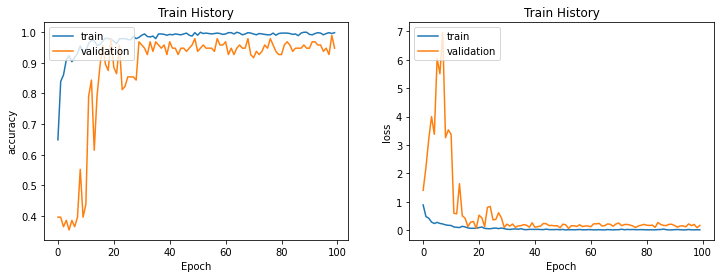

In [ ]:
plot(history)

The learning curve of ResNext trained in classifying 4 types of leukocytes, from the learning curve it can be seen that the model converges faster, reaching convergence in about 20 epochs, while the valisation accuracu reaches about 0.95, which has a higher value than the previously proposed CNN model

In [ ]:
def get_newimage(image, resize_height=200, resize_width=200, normalization=True):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 将BGR转为RGB
    rgb_image = cv2.resize(rgb_image, (resize_width, resize_height))
    rgb_image = np.asanyarray(rgb_image)
    if normalization:
        rgb_image = rgb_image / 255.
    rgb_image = rgb_image[np.newaxis, :]
    return rgb_image

In [ ]:
class_list = ["EOS", "LYT", "MON", "NGS"]
labels = list()
preds = list()
predict_list = list()
test_path = '/content/drive/MyDrive/new_data/test'

model = load_model('/content/models/best_model_ResNext.h5')
#model.summary()

In [ ]:
def get_files(path):
    file_list = []
    for maindir, subdir, file_name_list in os.walk(path):
        for filename in file_name_list:
            if ".tiff" in filename or ".jpg" in filename:
                apath = os.path.join(maindir,filename)
                file_list.append(apath)
    file_list.sort()
    return file_list

In [ ]:
import numpy as np
all_files = get_files(test_path)
for file in all_files:
    print(file)
    label = int(file.split("/")[-2])
    labels.append(label-1)
    image = cv2.imread(file)
    res = model.predict(get_newimage(image))
    res = np.argmax(res)
    preds.append(res)
    if label-1 == res:
        predict_list.append(1)
    else:
        predict_list.append(0)

/content/drive/MyDrive/new_data/test/1/EOS110.tiff
/content/drive/MyDrive/new_data/test/1/EOS111.tiff
/content/drive/MyDrive/new_data/test/1/EOS117.tiff
/content/drive/MyDrive/new_data/test/1/EOS19.tiff
/content/drive/MyDrive/new_data/test/1/EOS2.tiff
/content/drive/MyDrive/new_data/test/1/EOS3.tiff
/content/drive/MyDrive/new_data/test/1/EOS30.tiff
/content/drive/MyDrive/new_data/test/1/EOS32.tiff
/content/drive/MyDrive/new_data/test/1/EOS33.tiff
/content/drive/MyDrive/new_data/test/1/EOS34.tiff
/content/drive/MyDrive/new_data/test/1/EOS38.tiff
/content/drive/MyDrive/new_data/test/1/EOS46.tiff
/content/drive/MyDrive/new_data/test/1/EOS48.tiff
/content/drive/MyDrive/new_data/test/1/EOS5.tiff
/content/drive/MyDrive/new_data/test/1/EOS55.tiff
/content/drive/MyDrive/new_data/test/1/EOS59.tiff
/content/drive/MyDrive/new_data/test/1/EOS6.tiff
/content/drive/MyDrive/new_data/test/1/EOS62.tiff
/content/drive/MyDrive/new_data/test/1/EOS72.tiff
/content/drive/MyDrive/new_data/test/1/EOS79.tiff
/

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1098 (Conv2D)           (None, 100, 100, 64  9472        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_106 (Batch  (None, 100, 100, 64  256        ['conv2d_1098[0][0]']            
 Normalization)                 )                                                           

In [ ]:
print("Accuracy：",sum(predict_list)/len(predict_list))

Accuracy： 0.9758454106280193


The test set accuracy of the ResNext model on four target classification tasks, it clearly has higher accuracy than the previous CNN, especially on the category of EOS

In [ ]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(labels, preds)
print(C)

[[21  0  0  2]
 [ 0 78  2  0]
 [ 0  1 45  0]
 [ 0  0  0 58]]


In [ ]:
import numpy as np
def plot_confusion_matrix(cm, classes, normalize, title):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    title_font = {'family': 'serif', 'color': 'black', 'weight': 'bold', 'size': 15}
    label_font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 10}
    plt.title(title, fontdict=title_font)
    plt.ylabel('True label',fontdict=label_font)
    plt.xlabel('Predicted label',fontdict=label_font)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.show()

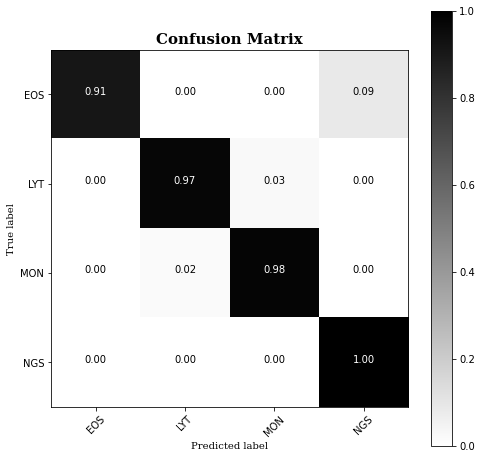

In [ ]:
# Compute confusion matrix
import itertools   
cnf_matrix = confusion_matrix(labels, preds)
np.set_printoptions(precision=2)
label_names = ["EOS", "LYT", "MON", "NGS"]
# Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=label_names, normalize=True, 
                      title='Confusion Matrix')

The confusion matrix shows that the model has a high classification accuracy on all four leukocytes,And the EOS category is mainly confused with NGS

In [ ]:
{i: v for i, v in enumerate(model.layers)}

{0: <keras.engine.input_layer.InputLayer at 0x7ff90ade2250>,
 1: <keras.layers.convolutional.Conv2D at 0x7ff90ade2710>,
 2: <keras.layers.normalization.batch_normalization.BatchNormalization at 0x7ff90ade2410>,
 3: <keras.layers.advanced_activations.LeakyReLU at 0x7ff90ade2bd0>,
 4: <keras.layers.pooling.MaxPooling2D at 0x7ff90ade2ed0>,
 5: <keras.layers.convolutional.Conv2D at 0x7ff90ade67d0>,
 6: <keras.layers.normalization.batch_normalization.BatchNormalization at 0x7ff90ade2210>,
 7: <keras.layers.advanced_activations.LeakyReLU at 0x7ff7375605d0>,
 8: <keras.layers.core.lambda_layer.Lambda at 0x7ff90ade6c50>,
 9: <keras.layers.core.lambda_layer.Lambda at 0x7ff90ade96d0>,
 10: <keras.layers.core.lambda_layer.Lambda at 0x7ff90ade9890>,
 11: <keras.layers.core.lambda_layer.Lambda at 0x7ff90ade9750>,
 12: <keras.layers.core.lambda_layer.Lambda at 0x7ff90ade9a10>,
 13: <keras.layers.core.lambda_layer.Lambda at 0x7ff90ade9b10>,
 14: <keras.layers.core.lambda_layer.Lambda at 0x7ff90ade9d5

The following is the output of feature maps performed at different layers

In [ ]:
test_path = '/content/drive/MyDrive/new_data/test/3/MON9.tiff'

In [ ]:
#model.layers[1].output

In [ ]:
model_1 = load_model('/content/models/best_model_ResNext.h5')
model_1 = Model(inputs=model.input, outputs=model.layers[1].output)

In [ ]:
def get_newimage(image, resize_height=200, resize_width=200, normalization=True):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 将BGR转为RGB
    rgb_image = cv2.resize(rgb_image, (resize_width, resize_height))
    rgb_image = np.asanyarray(rgb_image)
    if normalization:
        rgb_image = rgb_image / 255.
    rgb_image = rgb_image[np.newaxis, :]
    return rgb_image

In [ ]:
image = cv2.imread(test_path)
features = model_1.predict(get_newimage(image))
print(features.shape)
feature_maps = np.squeeze(features, axis=0)
num = feature_maps.shape[2]
all_feature_maps = list()

(1, 100, 100, 64)


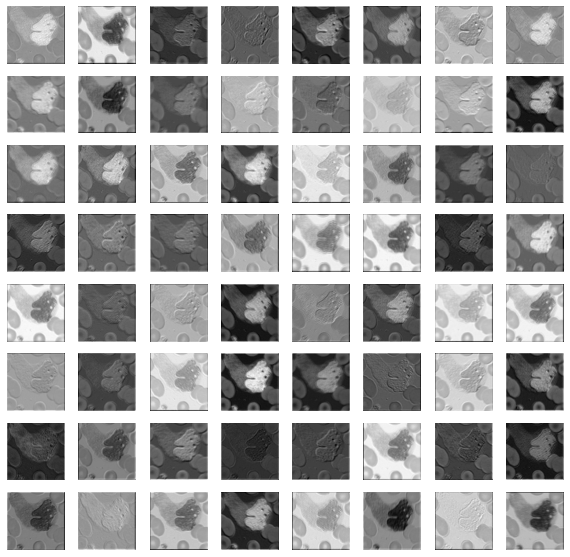

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(num):
    plt.subplot(8,8,i+1)
    all_feature_maps.append(feature_maps[:,:,i])
    plt.imshow(feature_maps[:,:,i],'gray')
    plt.axis('off')


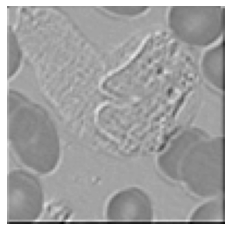

In [ ]:
sum_feature_map = sum(feature_map for feature_map in all_feature_maps)
plt.imshow(sum_feature_map,'gray')
plt.axis('off')
plt.show()


In [ ]:
model_2 = load_model('/content/models/best_model_ResNext.h5')
model_2 = Model(inputs=model.input, outputs=model.layers[225].output)

In [ ]:
image = cv2.imread(test_path)
features = model_2.predict(get_newimage(image))
print(features.shape)
feature_maps = np.squeeze(features, axis=0)
num = feature_maps.shape[2]
all_feature_maps = list()

(1, 50, 50, 256)


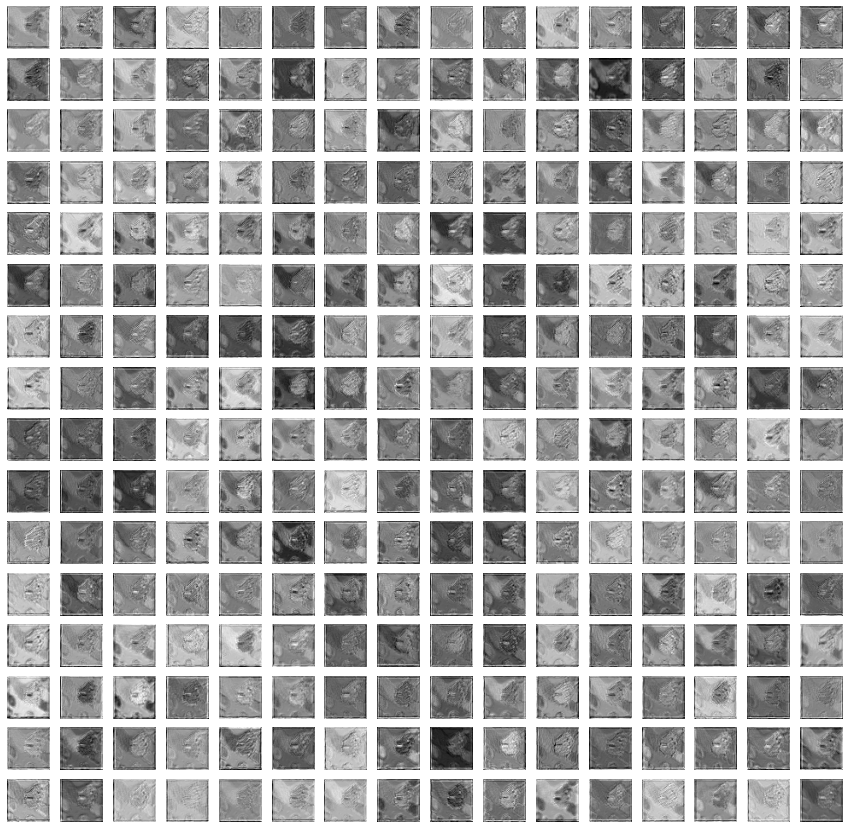

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(num):
    plt.subplot(16,16,i+1)
    all_feature_maps.append(feature_maps[:,:,i])
    plt.imshow(feature_maps[:,:,i],'gray')
    plt.axis('off')

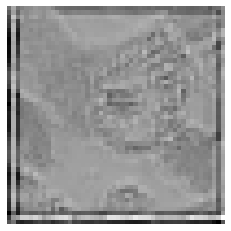

In [ ]:
sum_feature_map = sum(feature_map for feature_map in all_feature_maps)
plt.imshow(sum_feature_map,'gray')
plt.axis('off')
plt.show()

In [ ]:
model_3 = load_model('/content/models/best_model_ResNext.h5')
model_3 = Model(inputs=model.input, outputs=model.layers[523].output)

In [ ]:
image = cv2.imread(test_path)
features = model_3.predict(get_newimage(image))
print(features.shape)
feature_maps = np.squeeze(features, axis=0)
num = feature_maps.shape[2]
all_feature_maps = list()

(1, 25, 25, 512)


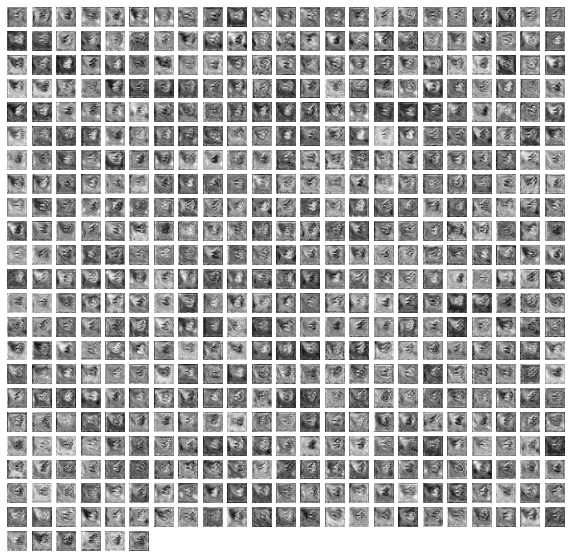

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(num):
    plt.subplot(23,23,i+1)
    all_feature_maps.append(feature_maps[:,:,i])
    plt.imshow(feature_maps[:,:,i],'gray')
    plt.axis('off')

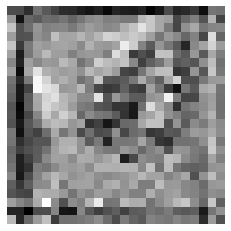

In [ ]:
sum_feature_map = sum(feature_map for feature_map in all_feature_maps)
plt.imshow(sum_feature_map,'gray')
plt.axis('off')
plt.show()

In [ ]:
i=1000
while i < 2000:
  print(i,model.layers[i])
  i=i+1

1000 <keras.layers.core.lambda_layer.Lambda object at 0x7ff73e72b850>
1001 <keras.layers.core.lambda_layer.Lambda object at 0x7ff73e72ba10>
1002 <keras.layers.core.lambda_layer.Lambda object at 0x7ff73e72bbd0>
1003 <keras.layers.core.lambda_layer.Lambda object at 0x7ff73e72bd90>
1004 <keras.layers.core.lambda_layer.Lambda object at 0x7ff73e72bf50>
1005 <keras.layers.core.lambda_layer.Lambda object at 0x7ff73e738150>
1006 <keras.layers.core.lambda_layer.Lambda object at 0x7ff73e738310>
1007 <keras.layers.core.lambda_layer.Lambda object at 0x7ff73e7384d0>
1008 <keras.layers.convolutional.Conv2D object at 0x7ff73e738650>
1009 <keras.layers.convolutional.Conv2D object at 0x7ff73e738690>
1010 <keras.layers.convolutional.Conv2D object at 0x7ff73e740250>
1011 <keras.layers.convolutional.Conv2D object at 0x7ff73e740910>
1012 <keras.layers.convolutional.Conv2D object at 0x7ff73e738b50>
1013 <keras.layers.convolutional.Conv2D object at 0x7ff73e7446d0>
1014 <keras.layers.convolutional.Conv2D obje

IndexError: ignored

In [ ]:
model_4 = load_model('/content/models/best_model_ResNext.h5')
model_4 = Model(inputs=model.input, outputs=model.layers[969].output)

In [ ]:
image = cv2.imread(test_path)
features = model_4.predict(get_newimage(image))
print(features.shape)
feature_maps = np.squeeze(features, axis=0)
num = feature_maps.shape[2]
all_feature_maps = list()

(1, 13, 13, 1024)


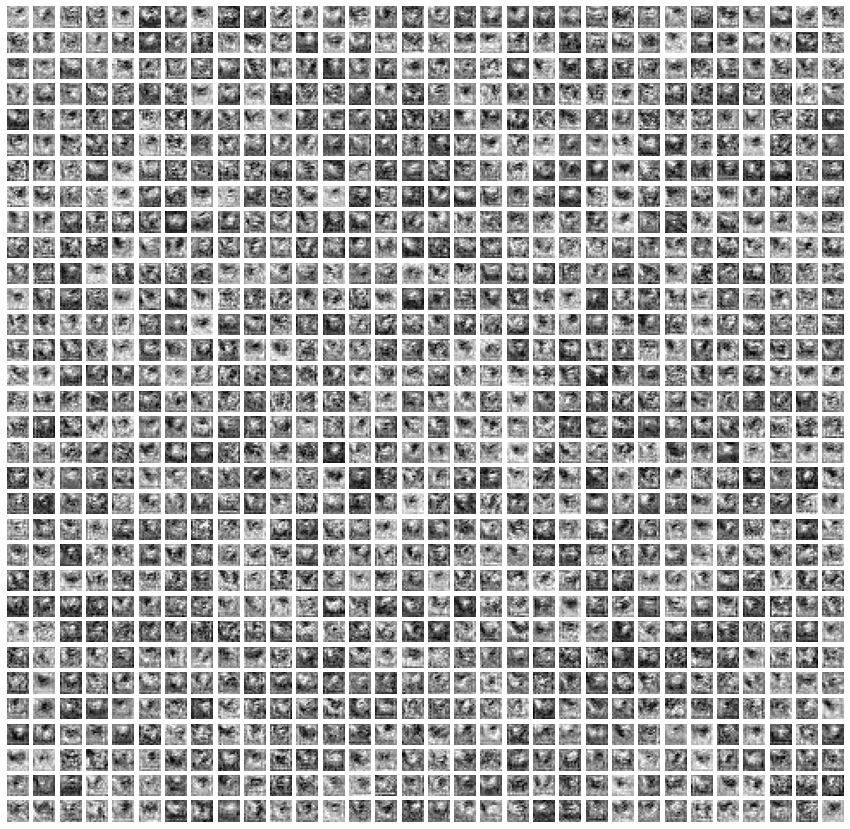

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(num):
    plt.subplot(32,32,i+1)
    all_feature_maps.append(feature_maps[:,:,i])
    plt.imshow(feature_maps[:,:,i],'gray')
    plt.axis('off')

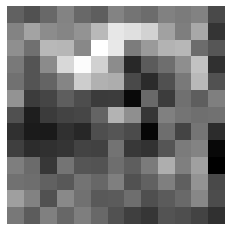

In [ ]:
sum_feature_map = sum(feature_map for feature_map in all_feature_maps)
plt.imshow(sum_feature_map,'gray')
plt.axis('off')
plt.show()

In [ ]:
model_5 = load_model('/content/models/best_model_ResNext.h5')
model_5 = Model(inputs=model.input, outputs=model.layers[1193].output)

In [ ]:
image = cv2.imread(test_path)
features = model_5.predict(get_newimage(image))
print(features.shape)
feature_maps = np.squeeze(features, axis=0)
num = feature_maps.shape[2]
all_feature_maps = list()

(1, 7, 7, 2048)


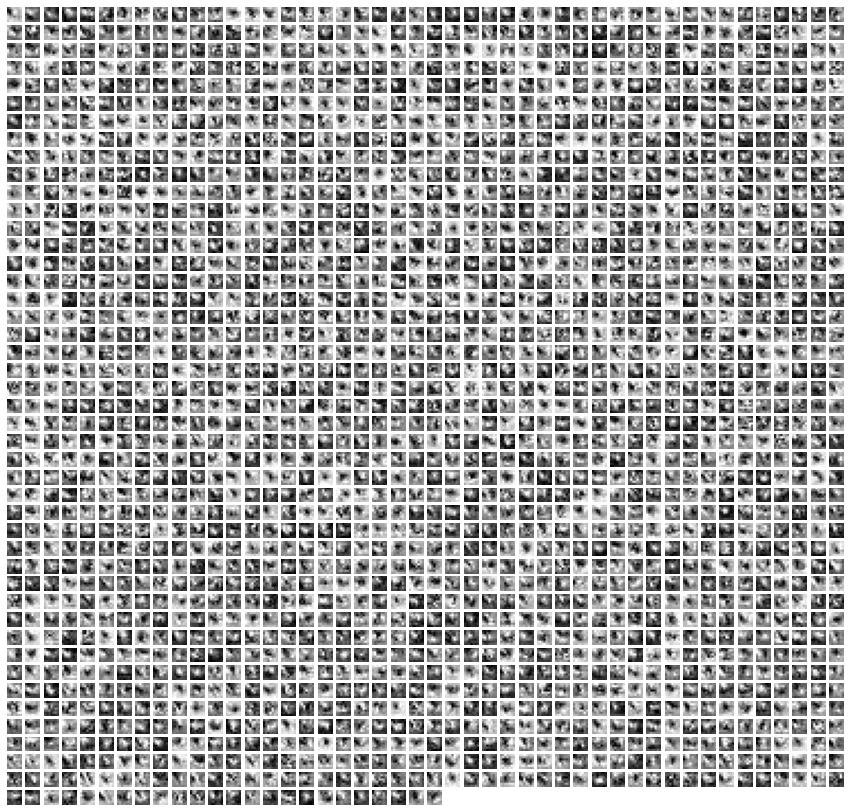

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(num):
    plt.subplot(46,46,i+1)
    all_feature_maps.append(feature_maps[:,:,i])
    plt.imshow(feature_maps[:,:,i],'gray')
    plt.axis('off')

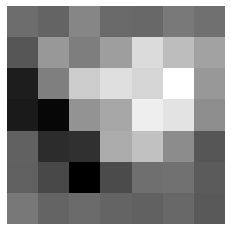

In [ ]:
sum_feature_map = sum(feature_map for feature_map in all_feature_maps)
plt.imshow(sum_feature_map,'gray')
plt.axis('off')
plt.show()

As can be seen from the feature map above, ResNext is able to learn more abstract features because it has more convolutional layers and a more advanced architecture than the previously proposed CNN

The following ResNext network is trained for images size of 400x400 and with BAS added as a new classification target.
The ratio of training set, validation set and test set is 7:1:2

In [100]:
from keras import layers
from keras import models


#
# image dimensions
#

img_height = 400
img_width = 400
img_channels = 3

#
# network params
#

cardinality = 32


def residual_network(x):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:

        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.LeakyReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 128, 256, _project_shortcut=project_shortcut)

    # conv3
    for i in range(4):
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 256, 512, _strides=strides)

    # conv4
    for i in range(6):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 512, 1024, _strides=strides)

    # conv5
    for i in range(3):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 1024, 2048, _strides=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(5,activation='softmax')(x)

    return x


In [101]:
image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = residual_network(image_tensor)

In [102]:
model = models.Model(inputs=[image_tensor], outputs=[network_output])
#print(model.summary())

In [103]:
import os
import cv2
from keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
import numpy as np

In [104]:
optimizer = Adam(learning_rate=1e-4)  # Using Adam instead of SGD to speed up training
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
print("Finished compiling")
print("Building model...")

Finished compiling
Building model...


In [105]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                               rotation_range=15,
                               width_shift_range=10./400,
                               height_shift_range=10./400,
                               horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255,
                               rotation_range=15,
                               width_shift_range=10./400,
                               height_shift_range=10./400,
                               horizontal_flip=True)

In [106]:
train_dir = '/content/drive/MyDrive/new_data_1/train'
validation_dir = '/content/drive/MyDrive/new_data_1/val'
all_classes = [str(i) for i in range(1, 6)]

In [107]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(400, 400), 
    batch_size=16,
    classes=all_classes,
    class_mode='categorical',
    shuffle=True)

Found 786 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


In [108]:
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(400, 400),
    batch_size=16,
    classes=all_classes,
    class_mode='categorical',
    shuffle=True)

Found 112 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


In [109]:
model_checkpoint = ModelCheckpoint('./models/best_model_ResNext_1.h5', monitor='val_loss',
                                   verbose=1, save_best_only=True)

In [110]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1),
                               cooldown=0, patience=10, min_lr=1e-6)

In [111]:
callbacks = [lr_reducer, model_checkpoint]

In [112]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.samples // 16,
                              epochs=100,
                              verbose=1,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=validation_generator.samples // 16,
                              shuffle=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 1.0507 - accuracy: 0.6104
Epoch 1: val_loss improved from inf to 1.90812, saving model to ./models/best_model_ResNext_1.h5
49/49 [==============================] - 223s 4s/step - loss: 1.0507 - accuracy: 0.6104 - val_loss: 1.9081 - val_accuracy: 0.2589 - lr: 1.0000e-04
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 0.5592 - accuracy: 0.8039
Epoch 2: val_loss did not improve from 1.90812
49/49 [==============================] - 48s 985ms/step - loss: 0.5592 - accuracy: 0.8039 - val_loss: 2.3067 - val_accuracy: 0.3571 - lr: 1.0000e-04
Epoch 3/100
49/49 [==============================] - ETA: 0s - loss: 0.3984 - accuracy: 0.8481
Epoch 3: val_loss did not improve from 1.90812
49/49 [==============================] - 48s 985ms/step - loss: 0.3984 - accuracy: 0.8481 - val_loss: 5.1266 - val_accuracy: 0.2589 - lr: 1.0000e-04
Epoch 4/100
49/49 [==============================] - ETA: 0s - loss: 0.3569 - a

In [113]:
%matplotlib inline

In [114]:
import matplotlib
matplotlib.rcParams['backend'] = "Qt4Agg"

In [115]:
def show_train_history(train_history,train_metrics,validation_metrics):
    plt.plot(train_history.history[train_metrics])
    plt.plot(train_history.history[validation_metrics])
    plt.title('Train History')
    plt.ylabel(train_metrics)
    plt.xlabel('Epoch')
    plt.legend(['train','validation'],loc='upper left')

def plot(history):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    show_train_history(history,'accuracy','val_accuracy')
    plt.subplot(1,2,2)
    show_train_history(history,'loss','val_loss')
    plt.show()

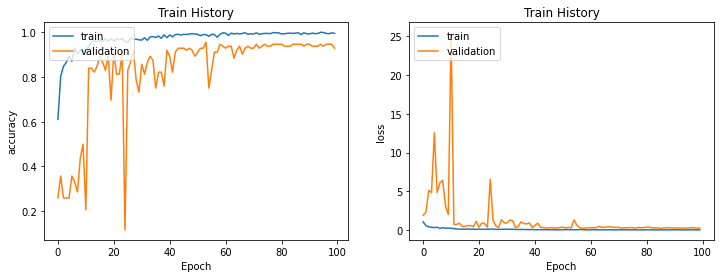

In [116]:
plot(history)

In [131]:
def get_newimage(image, resize_height=400, resize_width=400, normalization=True):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 将BGR转为RGB
    rgb_image = cv2.resize(rgb_image, (resize_width, resize_height))
    rgb_image = np.asanyarray(rgb_image)
    if normalization:
        rgb_image = rgb_image / 255.
    rgb_image = rgb_image[np.newaxis, :]
    return rgb_image

In [132]:
class_list = ["EOS", "LYT", "MON", "NGS","BAS"]
labels = list()
preds = list()
predict_list = list()
test_path = '/content/drive/MyDrive/new_data_1/test'

model = load_model('/content/models/best_model_ResNext_1.h5')
#model.summary()

In [133]:
def get_files(path):
    file_list = []
    for maindir, subdir, file_name_list in os.walk(path):
        for filename in file_name_list:
            if ".tiff" in filename or ".jpg" in filename:
                apath = os.path.join(maindir,filename)
                file_list.append(apath)
    file_list.sort()
    return file_list

In [134]:
import numpy as np
all_files = get_files(test_path)
for file in all_files:
    print(file)
    label = int(file.split("/")[-2])
    labels.append(label-1)
    image = cv2.imread(file)
    res = model.predict(get_newimage(image))
    res = np.argmax(res)
    preds.append(res)
    if label-1 == res:
        predict_list.append(1)
    else:
        predict_list.append(0)

/content/drive/MyDrive/new_data_1/test/1/EOS_0096.tiff
/content/drive/MyDrive/new_data_1/test/1/EOS_0097.tiff
/content/drive/MyDrive/new_data_1/test/1/EOS_0098.tiff
/content/drive/MyDrive/new_data_1/test/1/EOS_0099.tiff
/content/drive/MyDrive/new_data_1/test/1/EOS_0100.tiff
/content/drive/MyDrive/new_data_1/test/1/EOS_0101.tiff
/content/drive/MyDrive/new_data_1/test/1/EOS_0102.tiff
/content/drive/MyDrive/new_data_1/test/1/EOS_0103.tiff
/content/drive/MyDrive/new_data_1/test/1/EOS_0104.tiff
/content/drive/MyDrive/new_data_1/test/1/EOS_0105.tiff
/content/drive/MyDrive/new_data_1/test/1/EOS_0106.tiff
/content/drive/MyDrive/new_data_1/test/1/EOS_0107.tiff
/content/drive/MyDrive/new_data_1/test/1/EOS_0108.tiff
/content/drive/MyDrive/new_data_1/test/1/EOS_0109.tiff
/content/drive/MyDrive/new_data_1/test/1/EOS_0110.tiff
/content/drive/MyDrive/new_data_1/test/1/EOS_0111.tiff
/content/drive/MyDrive/new_data_1/test/1/EOS_0112.tiff
/content/drive/MyDrive/new_data_1/test/1/EOS_0113.tiff
/content/d

In [135]:
print("Accuracy：",sum(predict_list)/len(predict_list))

Accuracy： 0.9464285714285714


In [136]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(labels, preds)
print(C)

[[23  0  0  0  0]
 [ 0 76  2  1  1]
 [ 0  2 43  0  1]
 [ 1  0  0 57  1]
 [ 0  2  0  1 13]]


In [137]:
import numpy as np
def plot_confusion_matrix(cm, classes, normalize, title):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    title_font = {'family': 'serif', 'color': 'black', 'weight': 'bold', 'size': 15}
    label_font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 10}
    plt.title(title, fontdict=title_font)
    plt.ylabel('True label',fontdict=label_font)
    plt.xlabel('Predicted label',fontdict=label_font)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.show()

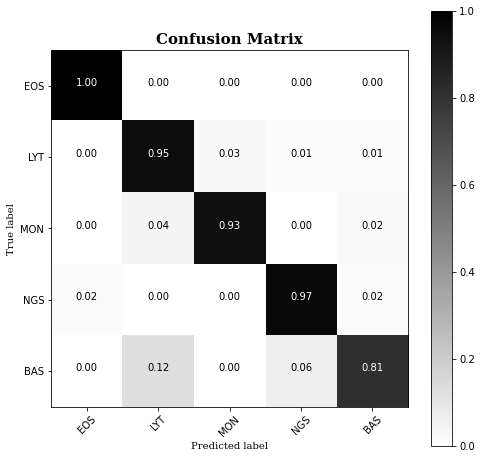

In [138]:
# Compute confusion matrix
import itertools   
cnf_matrix = confusion_matrix(labels, preds)
np.set_printoptions(precision=2)
label_names = ["EOS", "LYT", "MON", "NGS","BAS"]
# Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=label_names, normalize=True, 
                      title='Confusion Matrix')

From the classification results, the accuracy is still high on the original 4 cells, but not on the newly added BAS, because the data set is not much, compared to the same model with a training set of 6 and a test set of 3, the model will fluctuate more during training, while there will be a significant drop and then rebound, the accuracy of the model on BAS is higher than the Exp2 model, because the test set is smaller and the samples are not many, but the overall difference is not much, and the training time is ban ge x more than the Exp2 model.